# Introduction
In this introductory tutorial for MLflow Custom Pyfunc, we will delve into the core features of the PythonModel class and explore how to use them to build a very simple model that can be saved, loaded, and used for inference.

Objective: By the end of this guide, you will learn how to:

Define a custom PyFunc model using Python classes.

Understand the core components of the PyFunc flavor.

Save, load, and predict using the custom PyFunc model.

Leverage the power of MLflow’s PyFunc for a real-world example: the Lissajous curve.



# The PythonModel class
MLflow’s approach for generic model instance types takes a strict approach to standardization to ensure that any model that is stored with MLflow can be used for inference, provided that the implementation guidelines are adhered to.

There are two ways in order to create a custom PythonModel instance. The first, which is what we are going to be using in this guide, involves defining a class and methods that will be used for the interface. There is another approach that can be used, which is to define a function named predict and logging that as the python_model argument in mlflow.pyfunc.save_model(). This approach is more limited, but for implementations in which the entire logic of prediction can be encapsulated within a single function, it is preferrable. For this second mode of pyfunc logging, a generic PythonModel class will be created and logged for you with your provided predict function added as the predict() method within the class.



# Core PythonModel components
MLflow’s PyFunc revolves around the PythonModel class. The two essential methods in this class are: 1. load_context(self, context): This method is used to load artifacts or other initialization tasks. It is optional and can be used to fetch external references. 2. predict(self, context, model_input, params=None): This is the entry point of your model when predictions are made. It must be defined for your custom PyFunc model.

For instance, if your model uses an external library like XGBoost, you can load the XGBoost model in the load_context method and use it in the predict method.



# Basic Guidelines for a PythonModel
The guidelines for this approach are as follows:

Your class must be a subclass of mlflow.pyfunc.PythonModel

Your class must implement a predict method

The predict method must adhere to the requirements of the Inference API.

The predict method must have reference to context as the first named argument

If you wish to provide parameters with your model, these must be defined as part of the model signature. The signature must be saved along with the model.

If you intend to have additional functionality execute when loading the model (such as loading additional dependent files), you may decide to define the load_context method in your class.



# Define a simple Python Model
For this tutorial, we won’t be covering the more advanced load_context or interfacing with the context argument within the predict method. We’ll keep this simple for purposes of understanding the most basic aspects of a custom PythonModel.

For the purposes of showing additional usages of an MLflow custom Pyfunc model, we won’t be looking at the typical library use cases. Instead, we’ll take a look at using MLflow to store a configured instance of a Lissajous implementation.



# Lissajous curves
Originating from the field of harmonics, Lissajous curves are parametric sinusoidal curves defined by:

    x(t)=Asin(at+δ)

    y(t)=Bsin(bt)

    Where:

    (A) and ( B) are the amplitudes of the curves along the x and y axes respectively.

    (a) and ( b) determine the frequency of oscillations.

    ( δ) is the phase difference between the x and y components.

We’ll be creating a simple model that will allow users to generate different patterns associated with the ratios of frequency oscillations and their phases.



# Step 1: Define the Custom PyFunc Model
We begin by defining a Python class for our custom model. The class should inherit from mlflow.pyfunc.PythonModel.

In our Lissajous model, we initialize it with parameters ( A), ( B), and num_points. The predict method is responsible for plotting the Lissajous curve based on inputs ( a), ( b), and ( δ).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import mlflow.pyfunc
from mlflow.models import infer_signature


class Lissajous(mlflow.pyfunc.PythonModel):
    def __init__(self, A=1, B=1, num_points=1000):
        self.A = A
        self.B = B
        self.num_points = num_points
        self.t_range = (0, 2 * np.pi)

    def generate_lissajous(self, a, b, delta):
        t = np.linspace(self.t_range[0], self.t_range[1], self.num_points)
        x = self.A * np.sin(a * t + delta)
        y = self.B * np.sin(b * t)
        return pd.DataFrame({"x": x, "y": y})

    def predict(self, context, model_input, params=None):
        """
        Generate and plot the Lissajous curve with annotations for parameters.

        Args:
        - model_input (pd.DataFrame): DataFrame containing columns 'a' and 'b'.
        - params (dict, optional): Dictionary containing optional parameter 'delta'.
        """
        # Extract a and b values from the input DataFrame
        a = model_input["a"].iloc[0]
        b = model_input["b"].iloc[0]

        # Extract delta from params or set it to 0 if not provided
        delta = params.get("delta", 0)

        # Generate the Lissajous curve data
        df = self.generate_lissajous(a, b, delta)

        sns.set_theme()

        # Create the plot components
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.plot(df["x"], df["y"])
        ax.set_title("Lissajous Curve")

        # Define the annotation string
        annotation_text = f"""
        A = {self.A}
        B = {self.B}
        a = {a}
        b = {b}
        delta = {np.round(delta, 2)} rad
        """

        # Add the annotation with a bounding box outside the plot area
        ax.annotate(
            annotation_text,
            xy=(1.05, 0.5),
            xycoords="axes fraction",
            fontsize=12,
            bbox={"boxstyle": "round,pad=0.25", "facecolor": "aliceblue", "edgecolor": "black"},
        )

        # Adjust plot borders to make space for the annotation
        plt.subplots_adjust(right=0.65)
        plt.close()

        # Return the plot
        return fig


/home/jovyan/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jovyan/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


# Step 2: Save the Model
Once our model class is defined, we can instantiate it and save it using MLflow. The infer_signature method is useful here to automatically deduce the input and output schema for the model.

Because we are using params for overriding the delta value of the equation, we need to provide the signature of the model during saving. Failing to define this here means that usages of the loaded instance of this model (if saved without a signature) will ignore provided params (with a warning).

In [3]:
model_path = "lissajous_model"

In [4]:
!rm -rf {model_path}

In [5]:
# Define the path to save the model

# Create an instance of the model, overriding the default instance variables `A`, `B`, and `num_points`
model_10k_standard = Lissajous(1, 1, 10_000)

# Infer the model signature, ensuring that we define the params that will be available for customization at inference time
signature = infer_signature(pd.DataFrame([{"a": 1, "b": 2}]), params={"delta": np.pi / 5})

# Save our custom model to the path we defined, with the signature that we declared
mlflow.pyfunc.save_model(path=model_path, python_model=model_10k_standard, signature=signature)

/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# Step 3: Load the Model
After saving, we can load the model back and use it for predictions. Here, our prediction is the Lissajous curve plot.


In [6]:
# Load our custom model from the local artifact store
loaded_pyfunc_model = mlflow.pyfunc.load_model(model_path)

# Step 4: Use the model for generating curves

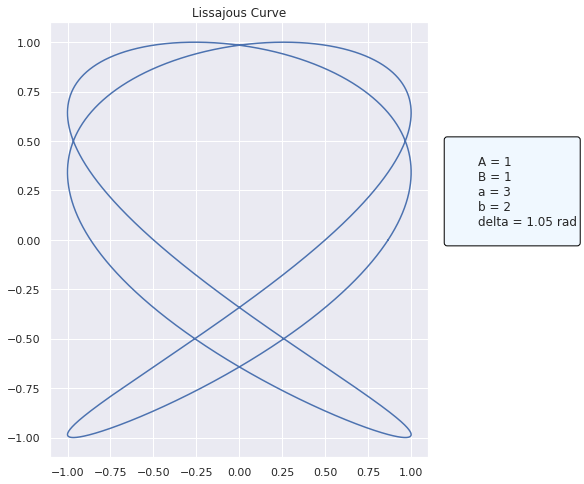

In [7]:
# Define the input DataFrame. In our custom model, we're reading only the first row of data to generate a plot.
model_input = pd.DataFrame({"a": [3], "b": [2]})

# Define a params override for the `delta` parameter
params = {"delta": np.pi / 3}

# Run predict, which will call our internal method `generate_lissajous` before generating a `matplotlib` plot showing the curve
fig = loaded_pyfunc_model.predict(model_input, params)

# Display the plot
fig

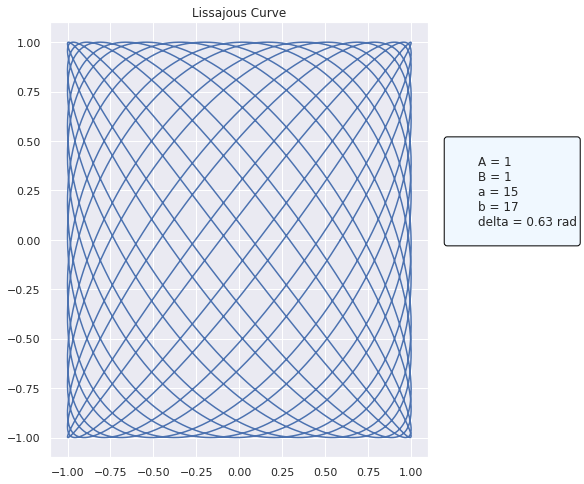

In [8]:
# Try a different configuration of arguments
fig2 = loaded_pyfunc_model.predict(
    pd.DataFrame({"a": [15], "b": [17]}), params={"delta": np.pi / 5}
)

fig2

# Customizing a Model’s predict method
In this tutorial, we will explore the process of customizing the predict method of a model in the context of MLflow’s PyFunc flavor. This is particularly useful when you want to have more flexibility in how your model behaves after you’ve deployed it using MLflow.

To illustrate this, we’ll use the famous Iris dataset and build a basic Logistic Regression model with scikit-learn.

In [9]:
from joblib import dump
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import mlflow
from mlflow.models import infer_signature
from mlflow.pyfunc import PythonModel

In [10]:
remote_server_uri = "http://localhost:5005"  # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)
import os
os.environ['MLFLOW_S3_ENDPOINT_URL'] = "http://172.19.164.128:9000"
os.environ['MLFLOW_ARTIFACT_URI'] = "s3://mlflow-artifacts/mlflow"
os.environ['AWS_ACCESS_KEY_ID'] = "zL8jRR2H28UZ6k2ZSTGe"
os.environ['AWS_SECRET_ACCESS_KEY'] = "0g23JxsUWV9LovRCuXZbazkMwXgXpEd7kPuKbCxc" 

In [11]:
import os
os.environ['MLFLOW_TRACKING_USERNAME'] = "cuong"
os.environ['MLFLOW_TRACKING_PASSWORD'] = "ds@cuong1"

Let’s begin by loading the Iris dataset and splitting it into training and testing sets. We’ll then train a simple Logistic Regression model on the training data.

In [12]:
iris = load_iris()
x = iris.data[:, 2:]
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9001)

model = LogisticRegression(random_state=0, max_iter=5_000, solver="newton-cg").fit(x_train, y_train)

This is a common scenario in machine learning. We have a trained model, and we want to use it to make predictions. With scikit-learn, the model provides a few methods to do this:

predict - to predict class labels

predict_proba - to get class membership probabilities

predict_log_proba - to get logarithmic probabilities for each class

We can predict the class labels, as shown below.

In [13]:
model.predict(x_test)[:5]

array([1, 2, 2, 1, 0])

We can also get the class membership probability.

In [14]:
model.predict_proba(x_test)[:5]

array([[2.63986020e-03, 6.62183459e-01, 3.35176681e-01],
       [1.24645011e-04, 8.36504393e-02, 9.16224916e-01],
       [1.30873561e-04, 1.37649965e-01, 8.62219162e-01],
       [3.70883932e-03, 7.13033667e-01, 2.83257494e-01],
       [9.82596896e-01, 1.74030239e-02, 7.99199785e-08]])

As well as generate logarithmic probabilites for each class.

In [15]:
model.predict_log_proba(x_test)[:5]

array([[ -5.93702932,  -0.41221263,  -1.09309748],
       [ -8.99004077,  -2.4811086 ,  -0.0874934 ],
       [ -8.94127889,  -1.9830413 ,  -0.14824579],
       [ -5.5970363 ,  -0.33822664,  -1.26139892],
       [ -0.01755632,  -4.0511113 , -16.34223997]])

While using the model directly within the same Python session is straightforward, what happens when we want to save this model and load it elsewhere, especially when using MLflow’s PyFunc flavor? Let’s explore this scenario.

In [17]:
sklearn_path = "/tmp/sklearn_model"

In [18]:
!rm -rf {sklearn_path}

In [19]:
mlflow.set_experiment("Overriding Predict Tutorial")

with mlflow.start_run(run_name='test1') as run:
    mlflow.sklearn.save_model(
        sk_model=model,
        path=sklearn_path,
        input_example=x_train[:2],
    )

2024/08/12 16:12:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run test1 at: http://localhost:5005/#/experiments/11/runs/b330531255d74677a560df6b70a9c6d7.
2024/08/12 16:12:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5005/#/experiments/11.


Once the model is loaded as a pyfunc, the default behavior only supports the predict method. This is evident when you try to call other methods like predict_proba, leading to an AttributeError. This can be limiting, especially when you want to preserve the full capability of the original model.

In [20]:
loaded_logreg_model = mlflow.pyfunc.load_model(sklearn_path)

In [21]:
loaded_logreg_model.predict(x_test)

array([1, 2, 2, 1, 0, 1, 2, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 2, 1,
       1, 0, 1, 1, 0, 0, 1, 2])

This works precisely as we expect. The output is the same as the model direct usage prior to saving.

Let’s try to use the predict_proba method.

We’re not actually going to run this, as it will raise an Exception. Here is the behavior if we try to execute this:

In [22]:
loaded_logreg_model.predict_proba(x_text)

AttributeError: 'PyFuncModel' object has no attribute 'predict_proba'

# What can we do to support the original behavior of the model when deployed?
We can create a custom pyfunc that overrides the behavior of the predict method.

For the example below, we’re going to be showing two features of pyfunc that can be leveraged to handle custom model logging capabilities:

override of the predict method

custom loading of an artifact

A key thing to note is the use of joblib for serialization. While pickle has been historically used for serializing scikit-learn models, joblib is now recommended as it provides better performance and support, especially for large numpy arrays.

We’ll be using joblib and it’s dump and load APIs to handle loading of our model object into our custom pyfunc implementation. This process of using the load_context method to handle loading files when instantiating the pyfunc object is particularly useful for models that have very large or numerous artifact dependencies (such as LLMs) and can help to dramatically lessen the total memory footprint of a pyfunc that is being loaded in a distributed system (such as Apache Spark or Ray).

In [23]:
from joblib import dump

from mlflow.models import infer_signature
from mlflow.pyfunc import PythonModel

To see how we can leverage the load_context functionality within a custom Python Model, we’ll first serialize our model locally using joblib. The usage of joblib here is purely to demonstrate a non-standard method (one that is not natively supported in MLflow) to illustrate the flexibility of the Python Model implementation. Provided that we import this library within the load_context and have it available in the environment where we will be loading this model, the model artifact will be deserialized properly.

In [24]:
model_directory = "/tmp/sklearn_model.joblib"
dump(model, model_directory)

['/tmp/sklearn_model.joblib']

# Defining our custom PythonModel
The ModelWrapper class below is an example of a custom pyfunc that extends MLflow’s PythonModel. It provides flexibility in the prediction method by using the params argument of the predict method. This way, we can specify if we want the regular predict, predict_proba, or predict_log_proba behavior when we call the predict method on the loaded pyfunc instance.

In [25]:
class ModelWrapper(PythonModel):
    def __init__(self):
        self.model = None

    def load_context(self, context):
        from joblib import load

        self.model = load(context.artifacts["model_path"])

    def predict(self, context, model_input, params=None):
        params = params or {"predict_method": "predict"}
        predict_method = params.get("predict_method")

        if predict_method == "predict":
            return self.model.predict(model_input)
        elif predict_method == "predict_proba":
            return self.model.predict_proba(model_input)
        elif predict_method == "predict_log_proba":
            return self.model.predict_log_proba(model_input)
        else:
            raise ValueError(f"The prediction method '{predict_method}' is not supported.")


After defining the custom pyfunc, the next steps involve saving the model with MLflow and then loading it back. The loaded model will retain the flexibility we built into the custom pyfunc, allowing us to choose the prediction method dynamically.

NOTE: The artifacts reference below is incredibly important. In order for the load_context to have access to the path that we are specifying as the location of our saved model, this must be provided as a dictionary that maps the appropriate access key to the relevant value. Failing to provide this dictionary as part of the mlflow.save_model() or mlflow.log_model() will render this custom pyfunc model unable to be properly loaded.

In [26]:
# Define the required artifacts associated with the saved custom pyfunc
artifacts = {"model_path": model_directory}

# Define the signature associated with the model
signature = infer_signature(x_train, params={"predict_method": "predict_proba"})


We can see how the defined params are used within the signature definition. As is shown below, the params receive a slight alteration when logged. We have a param key that is defined (predict_method), and expected type (string), and a default value. What this ends up meaning for this params definition is:

We can only provide a params override for the key predict_method. Anything apart from this will be ignored and a warning will be shown indicating that the unknown parameter will not be passed to the underlying model.

The value associated with predict_method must be a string. Any other type will not be permitted and will raise an Exception for an unexpected type.

If no value for the predict_method is provided when calling predict, the default value of predict_proba will be used by the model.

In [27]:
signature

inputs: 
  [Tensor('float64', (-1, 2))]
outputs: 
  None
params: 
  ['predict_method': string (default: predict_proba)]

We can now save our custom model. We’re providing a path to save it to, as well as the artifacts definition that contains the location of the manually serialized instance that we stored via joblib. Also included is the signature, which is a key component to making this example work; without the paramater defined within the signature, we wouldn’t be able to override the method of prediction that the predict method will use.

Note that we’re overriding the pip_requirements here to ensure that we specify the requirements for our two dependent libraries: joblib and sklearn. This helps to ensure that whatever environment that we deploy this model to will pre-load both of these dependencies prior to loading this saved model.

In [29]:
pyfunc_path = "/tmp/dynamic_regressor"

In [30]:
!rm -rf {pyfunc_path}

In [31]:
with mlflow.start_run() as run:
    mlflow.pyfunc.save_model(
        path=pyfunc_path,
        python_model=ModelWrapper(),
        input_example=x_train,
        signature=signature,
        artifacts=artifacts,
        pip_requirements=["joblib", "sklearn"],
    )

2024/08/12 16:13:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-colt-703 at: http://localhost:5005/#/experiments/11/runs/43553526bdc44446821555cb5bd4cf42.
2024/08/12 16:13:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5005/#/experiments/11.


In [32]:
loaded_dynamic = mlflow.pyfunc.load_model(pyfunc_path)

In [33]:
loaded_dynamic.predict(x_test)

array([[2.63986020e-03, 6.62183459e-01, 3.35176681e-01],
       [1.24645011e-04, 8.36504393e-02, 9.16224916e-01],
       [1.30873561e-04, 1.37649965e-01, 8.62219162e-01],
       [3.70883932e-03, 7.13033667e-01, 2.83257494e-01],
       [9.82596896e-01, 1.74030239e-02, 7.99199785e-08],
       [6.53971752e-03, 7.53980682e-01, 2.39479600e-01],
       [2.30147103e-06, 1.29718492e-02, 9.87025849e-01],
       [9.71313213e-01, 2.86866222e-02, 1.64768095e-07],
       [3.36795284e-01, 6.61251397e-01, 1.95331813e-03],
       [9.81875376e-01, 1.81244839e-02, 1.40238268e-07],
       [9.70731370e-01, 2.92684118e-02, 2.18211678e-07],
       [6.53971752e-03, 7.53980682e-01, 2.39479600e-01],
       [1.06934429e-02, 8.88082833e-01, 1.01223724e-01],
       [3.35035708e-03, 6.57571663e-01, 3.39077979e-01],
       [9.82239737e-01, 1.77601572e-02, 1.05867479e-07],
       [9.82596896e-01, 1.74030239e-02, 7.99199785e-08],
       [1.62646621e-03, 5.43435246e-01, 4.54938288e-01],
       [9.82596896e-01, 1.74030

In [34]:
loaded_dynamic.predict(x_test, params={"predict_method": "predict"})

array([1, 2, 2, 1, 0, 1, 2, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 2, 1,
       1, 0, 1, 1, 0, 0, 1, 2])

In [35]:
loaded_dynamic.predict(x_test, params={"predict_method": "predict_log_proba"})

array([[-5.93702932e+00, -4.12212633e-01, -1.09309748e+00],
       [-8.99004077e+00, -2.48110860e+00, -8.74934033e-02],
       [-8.94127889e+00, -1.98304130e+00, -1.48245793e-01],
       [-5.59703630e+00, -3.38226641e-01, -1.26139892e+00],
       [-1.75563181e-02, -4.05111130e+00, -1.63422400e+01],
       [-5.02986131e+00, -2.82388532e-01, -1.42928704e+00],
       [-1.29819621e+01, -4.34497371e+00, -1.30590501e-02],
       [-2.91062952e-02, -3.55132439e+00, -1.56187268e+01],
       [-1.08828000e+00, -4.13621182e-01, -6.23822574e+00],
       [-1.82908872e-02, -4.01049155e+00, -1.57799229e+01],
       [-2.97055020e-02, -3.53124644e+00, -1.53378002e+01],
       [-5.02986131e+00, -2.82388532e-01, -1.42928704e+00],
       [-4.53812454e+00, -1.18690260e-01, -2.29042212e+00],
       [-5.69868835e+00, -4.19201527e-01, -1.08152517e+00],
       [-1.79198691e-02, -4.03079769e+00, -1.60610777e+01],
       [-1.75563181e-02, -4.05111130e+00, -1.63422400e+01],
       [-6.42134559e+00, -6.09844723e-01

We’ve successfully created a pyfunc model that retains the full capabilities of the original scikit-learn model, while simultaneously using a custom loader methodology that eschews the standard pickle methodology.

This tutorial highlights the power and flexibility of MLflow’s PyFunc flavor, demonstrating how you can tailor it to fit your specific needs. As you continue building and deploying models, consider how custom pyfuncs can be used to enhance your model’s capabilities and adapt to various scenarios.

# Deploy an MLflow PyFunc model with Model Serving
In this notebook, learn how to deploy a custom MLflow PyFunc model to a serving endpoint. MLflow pyfunc offers greater flexibility and customization to your deployment. You can run any custom model, add preprocessing or post-processing logic, or execute any arbitrary Python code. While using the MLflow built-in flavor is recommended for optimal performance, you can use MLflow PyFunc models where more customization is required.



In [36]:
import json
import warnings

import numpy as np
import pandas as pd
import requests
from sklearn.ensemble import RandomForestRegressor

import mlflow
from mlflow.models import infer_signature

warnings.filterwarnings("ignore")

In [37]:
DOW_MODEL_NAME_PREFIX = "DOW_model_"
MME_MODEL_NAME = "MME_DOW_model"

# 1 - Create Some Sample Models
## 1.1 - Create Dummy Data


In [38]:
def create_weekly_dataset(n_dates, n_observations_per_date):
    rng = pd.date_range(start="today", periods=n_dates, freq="D")
    df = pd.DataFrame(
        np.random.randn(n_dates * n_observations_per_date, 4),
        columns=["x1", "x2", "x3", "y"],
        index=np.tile(rng, n_observations_per_date),
    )
    df["dow"] = df.index.dayofweek
    return df


df = create_weekly_dataset(n_dates=30, n_observations_per_date=500)
print(df.shape)
df.head()


(15000, 5)


,x1,x2,x3,y,dow
2024-08-12 16:13:45.091993,-1.294458,-1.459276,0.368083,-0.017327,0
2024-08-13 16:13:45.091993,-0.401969,0.120963,-0.850124,0.887752,1
2024-08-14 16:13:45.091993,1.875512,-0.141733,1.882587,-0.840686,2
2024-08-15 16:13:45.091993,0.017743,1.588724,0.246551,0.706815,3
2024-08-16 16:13:45.091993,-0.440160,-0.316904,-0.142256,1.310990,4


## 1.2 - Train Models for Each Day of the Week

In [39]:
for dow in df["dow"].unique():
    # Create dataset corresponding to a single day of the week
    X = df.loc[df["dow"] == dow]
    X.pop("dow")  # Remove DOW as a predictor column
    y = X.pop("y")

    # Fit our DOW model
    model = RandomForestRegressor().fit(X, y)

    # Infer signature of the model
    signature = infer_signature(X, model.predict(X))

    with mlflow.start_run():
        model_path = f"model_{dow}"

        # Log and register our DOW model with signature
        mlflow.sklearn.log_model(
            model,
            model_path,
            signature=signature,
            registered_model_name=f"{DOW_MODEL_NAME_PREFIX}{dow}",
        )
        mlflow.set_tag("dow", dow)


Successfully registered model 'DOW_model_0'.
2024/08/12 16:13:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DOW_model_0, version 1
Created version '1' of model 'DOW_model_0'.
2024/08/12 16:13:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run luminous-mule-171 at: http://localhost:5005/#/experiments/11/runs/81c78190da0240c6979151972ded887d.
2024/08/12 16:13:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5005/#/experiments/11.
Successfully registered model 'DOW_model_1'.
2024/08/12 16:13:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DOW_model_1, version 1
Created version '1' of model 'DOW_model_1'.
2024/08/12 16:13:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run gaudy-crane-989 at: http://localhost:5005/#/experiments/11/runs/019c7cc37f344b35b93ea45fc0968824.
202

## 1.3 - Test inference on our DOW models


In [40]:
# Load Tuesday's model
tuesday_dow = 1
model_name = f"{DOW_MODEL_NAME_PREFIX}{tuesday_dow}"
model_uri = f"models:/{model_name}/latest"
model = mlflow.sklearn.load_model(model_uri)

# Perform inference using our training data for Tuesday
predictor_columns = [column for column in df.columns if column not in {"y", "dow"}]
head_of_training_data = df.loc[df["dow"] == tuesday_dow, predictor_columns].head()
tuesday_fitted_values = model.predict(head_of_training_data)
print(tuesday_fitted_values)

[ 0.71599399 -1.33538244  0.61506644  0.37368974 -0.2087316 ]


# 2 - Create an MME Custom PyFunc Model
## 2.1 - Create a Child Implementation of mlflow.pyfunc.PythonModel

In [41]:
class DOWModel(mlflow.pyfunc.PythonModel):
    def __init__(self, model_uris):
        self.model_uris = model_uris
        self.models = {}

    @staticmethod
    def _model_uri_to_dow(model_uri: str) -> int:
        return int(model_uri.split("/")[-2].split("_")[-1])

    def load_context(self, context):
        self.models = {
            self._model_uri_to_dow(model_uri): mlflow.sklearn.load_model(model_uri)
            for model_uri in self.model_uris
        }

    def predict(self, context, model_input, params):
        # Parse the dow parameter
        dow = params.get("dow")
        if dow is None:
            raise ValueError("DOW param is not passed.")

        # Get the model associated with the dow parameter
        model = self.models.get(dow)
        if model is None:
            raise ValueError(f"Model {dow} version was not found: {self.models.keys()}.")

        # Perform inference
        return model.predict(model_input)


In [42]:
head_of_training_data

,x1,x2,x3
2024-08-13 16:13:45.091993,-0.401969,0.120963,-0.850124
2024-08-20 16:13:45.091993,-0.831842,-1.145147,0.516007
2024-08-27 16:13:45.091993,0.498573,-1.120308,-0.310086
2024-09-03 16:13:45.091993,-0.506387,-0.184389,-1.134990
2024-09-10 16:13:45.091993,0.663276,0.034180,2.233205


In [43]:
# Instantiate our DOW MME
model_uris = [f"models:/{DOW_MODEL_NAME_PREFIX}{i}/latest" for i in df["dow"].unique()]
dow_model = DOWModel(model_uris)
dow_model.load_context(None)
print("Model URIs:")
print(model_uris)

# Perform inference using our training data for Tuesday
params = {"dow": 1}
mme_tuesday_fitted_values = dow_model.predict(None, head_of_training_data, params=params)
assert all(tuesday_fitted_values == mme_tuesday_fitted_values)

print("\nTuesday fitted values:")
print(mme_tuesday_fitted_values)


Model URIs:
['models:/DOW_model_0/latest', 'models:/DOW_model_1/latest', 'models:/DOW_model_2/latest', 'models:/DOW_model_3/latest', 'models:/DOW_model_4/latest', 'models:/DOW_model_5/latest', 'models:/DOW_model_6/latest']

Tuesday fitted values:
[ 0.71599399 -1.33538244  0.61506644  0.37368974 -0.2087316 ]


## 2.3 - Register our Custom PyFunc Mode

In [44]:
with mlflow.start_run():
    # Instantiate the custom pyfunc model
    model = DOWModel(model_uris)
    model.load_context(None)
    model_path = "MME_model_path"

    signature = infer_signature(
        model_input=head_of_training_data,
        model_output=tuesday_fitted_values,
        params=params,
    )
    print(signature)

    # Log the model to the experiment
    mlflow.pyfunc.log_model(
        model_path,
        python_model=model,
        signature=signature,
        pip_requirements=["scikit-learn=1.3.2"],
        registered_model_name=MME_MODEL_NAME,  # also register the model for easy access
    )

    # Set some relevant information about our model
    # (Assuming model has a property 'models' that can be counted)
    mlflow.log_param("num_models", len(model.models))


inputs: 
  ['x1': double (required), 'x2': double (required), 'x3': double (required)]
outputs: 
  [Tensor('float64', (-1,))]
params: 
  ['dow': long (default: 1)]



Successfully registered model 'MME_DOW_model'.
2024/08/12 16:14:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: MME_DOW_model, version 1
Created version '1' of model 'MME_DOW_model'.
2024/08/12 16:14:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run angry-bat-502 at: http://localhost:5005/#/experiments/11/runs/562e80b653614b459468e6aefd3ef873.
2024/08/12 16:14:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5005/#/experiments/11.


# 3 - Serve our Model
To test our endpoint, let’s serve our model on our local machine. 1. Open a new shell window in the root containing mlruns directory e.g. the same directory you ran this notebook. 2. Ensure mlflow is installed: pip install --upgrade mlflow scikit-learn 3. Run the bash command printed below.

In [45]:
##### next project with different fw